In [13]:
import pandas as pd
import numpy as np

import clean_dataset
import optuna

In [2]:
all_df = clean_dataset.get_dataset()
mapping = clean_dataset.get_mapping()
all_df = clean_dataset.create_cols(all_df, mapping)

In [3]:
team_names = list(mapping.values())
assert len(team_names) == 32

In [4]:
# returns a train and test set copy of a given dataframe
def top_percent(df, percent):
    num_rows = df.shape[0]
    cutoff = int(num_rows*percent)
    return df.iloc[0:cutoff, :].copy(deep=True), df.iloc[cutoff:, :].copy(deep=True)

In [5]:
df_2024 = all_df.query("season == '2023-24 season:'")
df_2023 = all_df.query("season == '2022-23 season:'")

In [6]:
train_2024, val_df = top_percent(df_2024, 0.6)
train_df = pd.concat([df_2023, train_2024])

print(f"train size = {train_df.shape[0]}")
print(f"val size = {val_df.shape}")

train size = 1742
val size = (287, 14)


In [7]:
from sklearn.base import BaseEstimator
from sklearn import metrics
from copy import deepcopy

class EloClassifier(BaseEstimator):
    def __init__(self, team_names, initial_elo, k, alpha, home_adv, 
                 mov_exp, mov_bias, auto_coeff, auto_bias, k_mult=None, 
                 use_draw=False, elo_scores_dict=dict()):
        self.team_names = team_names
        self.initial_elo = initial_elo
        self.k = k
        self.alpha = alpha
        self.home_adv = home_adv
        self.mov_exp = mov_exp
        self.mov_bias = mov_bias
        self.auto_coeff = auto_coeff
        self.auto_bias = auto_bias
        self.elo_scores_dict = elo_scores_dict
        self.k_mult = k_mult
        self.use_draw = use_draw

    def create_initial_elo(self):
        keys = self.team_names
        values = self.initial_elo*np.ones(len(keys))
        self.elo_scores_dict = dict(zip(keys, values))
    
    def win_prob(self, team_rating: float, opponent_rating: float) -> float:
        return 1/(1 + np.power(10, -(team_rating - opponent_rating)/400))   # 1/(1 + 10^(-diff/400))
    
    # returns sorted list of all team rankings
    def return_sorted_list(self):
        return [(k,v) for k, v in sorted(self.elo_scores_dict.items(), key=lambda item: item[1], reverse=True)]
    
    def fit(self, df, y=None):
        
        self.create_initial_elo()
        current_season = df.iloc[0,:]['numeric_season']
        k_multiplier=1

        # iterate over every row of dataframe
        for row_index in range(len(df)):
            game_row = df.iloc[row_index, :]    # pandas series

            # check if season change
            if current_season < game_row['numeric_season']:
                self.elo_scores_dict.update( (k, self.alpha*v + (1-self.alpha)*self.initial_elo) for k, v in self.elo_scores_dict.items() )
                current_season = game_row['numeric_season']
            
            # get elo values of teams
            home_original_elo = self.elo_scores_dict[game_row['home_team']]
            away_original_elo = self.elo_scores_dict[game_row['away_team']]

            # calculate expected scores (probs)
            home_prob = self.win_prob(home_original_elo + self.home_adv, away_original_elo)
            away_prob = self.win_prob(away_original_elo, home_original_elo + self.home_adv)
            
            # Calculate new elo values
            if self.k_mult == '538':
                elo_diff = home_original_elo + self.home_adv - away_original_elo
                mov = np.abs(game_row['home_score'] - game_row['away_score'])
                k_multiplier = np.power(mov + self.mov_bias, self.mov_exp)/(self.auto_bias + self.auto_coeff*elo_diff)
            elif self.k_mult == '538_specific':
                elo_diff = home_original_elo + self.home_adv - away_original_elo
                mov = np.abs(game_row['home_score'] - game_row['away_score'])
                k_multiplier = (0.6686 * np.log(mov) + 0.8048) * (2.05 / (elo_diff * 0.001 + 2.05))
            elif self.k_mult == 'multiplicative':
                elo_diff = home_original_elo + self.home_adv - away_original_elo
                mov = np.abs(game_row['home_score'] - game_row['away_score'])/self.mov_bias
                k_multiplier = np.power( 1 + mov, self.mov_exp)
            else:
                k_multiplier = 1

            if self.use_draw and game_row['overtime']:  # treat it as a draw
                home_updated_elo = home_original_elo + self.k*k_multiplier*(0.5 - home_prob)
                away_updated_elo = away_original_elo + self.k*k_multiplier*(0.5 - away_prob)
            else:
                home_updated_elo = home_original_elo + self.k*k_multiplier*(game_row['home_win'] - home_prob)
                away_updated_elo = away_original_elo + self.k*k_multiplier*(game_row['away_win'] - away_prob)

            # update ELO values
            self.elo_scores_dict[game_row['home_team']] = home_updated_elo
            self.elo_scores_dict[game_row['away_team']] = away_updated_elo
            
    # update_ratings: boolean if you want the elo scores to update 
    # after the seen validation sample or not
    def predict_proba(self, df, update_ratings=True):
        current_season = df.iloc[0,:]['numeric_season']
        elo_dict = deepcopy(self.elo_scores_dict)
        probabilities = []
        k_multiplier=1

        # iterate over every row of dataframe
        for row_index in range(len(df)):
            game_row = df.iloc[row_index, :]    # pandas series

            # check if season change
            if current_season < game_row['numeric_season']:
                elo_dict.update( (k, self.alpha*v + (1-self.alpha)*self.initial_elo) for k, v in elo_dict.items() )
                current_season = game_row['numeric_season']
            
            # get elo values of teams
            home_original_elo = elo_dict[game_row['home_team']]
            away_original_elo = elo_dict[game_row['away_team']]
            # calculate expected scores (probs)
            home_prob = self.win_prob(home_original_elo + self.home_adv, away_original_elo)
            away_prob = self.win_prob(away_original_elo, home_original_elo + self.home_adv)
            probabilities.append([home_prob, away_prob])

            if update_ratings:
                # Calculate new elo values
                if self.k_mult == '538':
                    elo_diff = home_original_elo + self.home_adv - away_original_elo
                    mov = np.abs(game_row['home_score'] - game_row['away_score'])
                    k_multiplier = np.power(mov + self.mov_bias, self.mov_exp)/(self.auto_bias + self.auto_coeff*elo_diff)
                elif self.k_mult == '538_specific':
                    elo_diff = home_original_elo + self.home_adv - away_original_elo
                    mov = np.abs(game_row['home_score'] - game_row['away_score'])
                    k_multiplier = (0.6686 * np.log(mov) + 0.8048) * (2.05/(elo_diff * 0.001 + 2.05))
                elif self.k_mult == 'multiplicative':
                    elo_diff = home_original_elo + self.home_adv - away_original_elo
                    mov = np.abs(game_row['home_score'] - game_row['away_score'])/self.mov_bias
                    k_multiplier = np.power( 1 + mov, self.mov_exp)
                else:
                    k_multiplier = 1

                if self.use_draw and game_row['overtime']:  # treat it as a draw
                    home_updated_elo = home_original_elo + self.k*k_multiplier*(0.5 - home_prob)
                    away_updated_elo = away_original_elo + self.k*k_multiplier*(0.5 - away_prob)
                else:
                    home_updated_elo = home_original_elo + self.k*k_multiplier*(game_row['home_win'] - home_prob)
                    away_updated_elo = away_original_elo + self.k*k_multiplier*(game_row['away_win'] - away_prob)

                    # update ELO values
                    self.elo_scores_dict[game_row['home_team']] = home_updated_elo
                    self.elo_scores_dict[game_row['away_team']] = away_updated_elo
            
        return np.array(probabilities)

    def predict(self, X, update_ratings=True):
        probabilities = self.predict_proba(X, update_ratings)
        return np.argmax(probabilities, axis=1)
    
    def score(self, X, y, update_ratings=True):
        probabilities = self.predict_proba(X, update_ratings)
        return metrics.log_loss(y, probabilities[:, 0]) # take probabilities of home team 



In [9]:

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    initial_elo = 1500
    ALPHA = trial.suggest_float('alpha', 0.0, 1.0, step=0.1)
    K = trial.suggest_int("k", 0, 40, step=1)
    HOME_ADV = trial.suggest_int("home_adv", 0, 50, step=1)
    MOV_EXP = trial.suggest_float('mov_exp', 0.0, 3.0, step=0.1)
    MOV_BIAS = trial.suggest_float('mov_bias', 0.0, 5.0, step=0.1)
    AUTO_COEFF = trial.suggest_float('auto_coeff', 0.0, 0.1, step=0.001)
    AUTO_BIAS = trial.suggest_float('auto_bias', 1.0, 10.0, step=0.1)
    # MOV_EXP = 1
    # MOV_BIAS = 1
    # AUTO_COEFF = 1
    # AUTO_BIAS = 1

    elo_model = EloClassifier(team_names, initial_elo, K, ALPHA, HOME_ADV, MOV_EXP, MOV_BIAS, AUTO_COEFF, AUTO_BIAS, k_mult=True, use_draw=True)
    elo_model.fit(train_df)
    return elo_model.score(val_df, val_df[['home_win']].values, update_ratings=True)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(study.best_trial)


FrozenTrial(number=92, state=TrialState.COMPLETE, values=[0.6684915705932248], datetime_start=datetime.datetime(2024, 3, 21, 17, 10, 55, 609955), datetime_complete=datetime.datetime(2024, 3, 21, 17, 10, 55, 954543), params={'alpha': 1.0, 'k': 7, 'home_adv': 31, 'mov_exp': 0.5, 'mov_bias': 2.4000000000000004, 'auto_coeff': 0.089, 'auto_bias': 2.9000000000000004}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=0.1), 'k': IntDistribution(high=40, log=False, low=0, step=1), 'home_adv': IntDistribution(high=50, log=False, low=0, step=1), 'mov_exp': FloatDistribution(high=3.0, log=False, low=0.0, step=0.1), 'mov_bias': FloatDistribution(high=5.0, log=False, low=0.0, step=0.1), 'auto_coeff': FloatDistribution(high=0.1, log=False, low=0.0, step=0.001), 'auto_bias': FloatDistribution(high=10.0, log=False, low=1.0, step=0.1)}, trial_id=92, value=None)


In [8]:
home_win_percentage = all_df.home_win.sum()/all_df.shape[0]
print(f"league average home team win percentage = {np.round(home_win_percentage, 3)}")

league average home team win percentage = 0.529


In [14]:
# store information about a specific elo model, as fittd by given hyperparameters
def diagnostics(model_str, results_df, pred_prob_df, train_df, val_df, K, ALPHA, HOME_ADV, MOV_EXP=1, MOV_BIAS=1, AUTO_COEFF=1, AUTO_BIAS=1, K_MULTI=False, USE_DRAW=False, home_win_percentage=0.529):
    home_win_percentage = all_df.home_win.sum()/all_df.shape[0]
    
    elo_model = EloClassifier(team_names, 1500, k=K, alpha=ALPHA, home_adv=HOME_ADV, mov_exp=MOV_EXP, mov_bias=MOV_BIAS, auto_coeff=AUTO_COEFF, auto_bias=AUTO_BIAS, k_mult=K_MULTI, use_draw=USE_DRAW)
    elo_model.fit(train_df)
    log_loss = elo_model.score(val_df, val_df[['home_win']].values, update_ratings=True)
    predicted_home_win_prob = elo_model.win_prob(1500+HOME_ADV,1500)
    top_eight_rankings = elo_model.return_sorted_list()[0:8]
    bottom_four_rankings = elo_model.return_sorted_list()[-4:]
    
    results_df.loc[model_str] = [log_loss, np.round(predicted_home_win_prob - home_win_percentage,3)] + top_eight_rankings + bottom_four_rankings
    pred_prob_df[f"home_prob_{model_str}"] = elo_model.predict_proba(val_df)[:,0]
    
    

In [15]:
results_df = pd.DataFrame(columns=['log_loss', 'home_win_prob_diff', '1', '2', '3', '4', '5', '6', '7', '8', '-4', '-3', '-2', '-1'])
predicted_probs_df = deepcopy(val_df.loc[:,['date','home_team', 'away_team', 'score_diff']])

diagnostics("538_params", results_df, predicted_probs_df, train_df, val_df, 6, 0.7, 50, MOV_EXP=0, MOV_BIAS=0, AUTO_COEFF=0, AUTO_BIAS=0, K_MULTI='538_specific')
diagnostics("no_k_multi", results_df, predicted_probs_df, train_df, val_df, 6, 1.0, 32, MOV_EXP=1, MOV_BIAS=1, AUTO_COEFF=1, AUTO_BIAS=1, K_MULTI=False)
diagnostics("no_k_multi_use_draw", results_df, predicted_probs_df, train_df, val_df, 7, 1.0, 27, MOV_EXP=1, MOV_BIAS=1, AUTO_COEFF=1, AUTO_BIAS=1, K_MULTI=False, USE_DRAW=True)
diagnostics("k_multi_no_auto_coeff", results_df, predicted_probs_df, train_df, val_df, 3, 1.0, 28, MOV_EXP=0.7, MOV_BIAS=0.9, AUTO_COEFF=0.0, AUTO_BIAS=1.1, K_MULTI='538')
diagnostics("k_multi_no_auto_coeff_use_draw", results_df, predicted_probs_df, train_df, val_df, 3, 1.0, 28, MOV_EXP=0.7, MOV_BIAS=0.9, AUTO_COEFF=0.0, AUTO_BIAS=1.1, K_MULTI='538', USE_DRAW=True)
diagnostics("k_multi_small_auto_coeff_use_draw", results_df, predicted_probs_df, train_df, val_df, 12, 0.8, 28, MOV_EXP=1.5, MOV_BIAS=0.3, AUTO_COEFF=0.018, AUTO_BIAS=9.2, K_MULTI='538', USE_DRAW=True)
diagnostics("k_multi_multiplicative", results_df, predicted_probs_df, train_df, val_df, 29, 1.0, 47, MOV_EXP=0.4, MOV_BIAS=3.3, AUTO_COEFF=1, AUTO_BIAS=1, K_MULTI='multiplicative')

In [16]:
results_df

,log_loss,home_win_prob_diff,1,2,3,4,5,6,7,8,-4,-3,-2,-1
538_params,0.667089,0.043,"(Boston, 1600.402873295721)","(NY Rangers, 1557.1728537006936)","(Vegas, 1556.6388947316857)","(Los Angeles, 1556.4960245461882)","(Colorado, 1551.5501005955302)","(Dallas, 1548.5588058968444)","(Edmonton, 1545.2393719774434)","(Toronto, 1536.6396446872147)","(Chicago, 1420.6883124604783)","(Columbus, 1409.6955342651713)","(San Jose, 1407.0529011677697)","(Anaheim, 1406.2583882722054)"
no_k_multi,0.666334,0.017,"(Boston, 1608.3625819770161)","(Vegas, 1554.5725373751936)","(NY Rangers, 1553.533247924399)","(Colorado, 1553.0269967123975)","(Los Angeles, 1544.856700412897)","(Toronto, 1542.547587411123)","(Carolina, 1540.6294280917757)","(Edmonton, 1539.950874426994)","(Chicago, 1428.756329799601)","(Columbus, 1411.7030157642416)","(Anaheim, 1411.330337901672)","(San Jose, 1408.95691284118)"
no_k_multi_use_draw,0.668634,0.010,"(Boston, 1604.8693089163653)","(Los Angeles, 1560.070774504916)","(NY Rangers, 1558.8218917594377)","(Vegas, 1556.7951297491593)","(Colorado, 1547.8582334504906)","(Edmonton, 1547.8327469783526)","(Dallas, 1547.5830992968338)","(Toronto, 1540.8488001010576)","(San Jose, 1422.2030379206296)","(Columbus, 1414.6728471195647)","(Chicago, 1410.1819642175064)","(Anaheim, 1398.6759645687955)"
k_multi_no_auto_coeff,0.664869,0.011,"(Boston, 1616.0907500911542)","(Vegas, 1559.5622469426003)","(NY Rangers, 1559.3098398839966)","(Colorado, 1555.0287306055668)","(Los Angeles, 1553.622044130705)","(Dallas, 1553.072744868073)","(Edmonton, 1551.9744145388693)","(Toronto, 1546.2475104501286)","(Chicago, 1412.8674499042374)","(Columbus, 1399.0736633758297)","(San Jose, 1396.8451096425495)","(Anaheim, 1393.9667371744872)"
k_multi_no_auto_coeff_use_draw,0.666442,0.011,"(Boston, 1607.5643829924059)","(Los Angeles, 1559.630863082845)","(NY Rangers, 1559.0834597202997)","(Vegas, 1557.3035611065027)","(Dallas, 1557.2622812208258)","(Edmonton, 1554.2601451080734)","(Colorado, 1548.1610706161414)","(Toronto, 1542.9307145553937)","(San Jose, 1409.9666261701097)","(Columbus, 1405.7995418626854)","(Chicago, 1404.171567730812)","(Anaheim, 1391.7382584759303)"
k_multi_small_auto_coeff_use_draw,0.664477,0.011,"(Boston, 1601.0646830062885)","(Dallas, 1569.1801789013925)","(Los Angeles, 1563.8708258194545)","(Vegas, 1557.7539099876278)","(NY Rangers, 1555.9303720837281)","(Edmonton, 1552.9740681204003)","(Colorado, 1541.9531224431455)","(Toronto, 1541.5184317980422)","(Chicago, 1404.1246463544846)","(Columbus, 1403.6250618303206)","(San Jose, 1390.9307099445173)","(Anaheim, 1383.3402013173363)"
k_multi_multiplicative,0.689797,0.038,"(Boston, 1656.6599912993656)","(Los Angeles, 1628.7776039716575)","(NY Rangers, 1616.1246575455948)","(Edmonton, 1614.2808448386843)","(Vegas, 1611.0414897840526)","(Winnipeg, 1609.8868246294305)","(Dallas, 1585.6083420985856)","(Colorado, 1583.2242733679748)","(Chicago, 1372.9955725877526)","(Seattle, 1346.518639883216)","(Columbus, 1333.4113464604384)","(Anaheim, 1311.460800468155)"


In [17]:
predicted_probs_df

,date,home_team,away_team,score_diff,home_prob_538_params,home_prob_no_k_multi,home_prob_no_k_multi_use_draw,home_prob_k_multi_no_auto_coeff,home_prob_k_multi_no_auto_coeff_use_draw,home_prob_k_multi_small_auto_coeff_use_draw,home_prob_k_multi_multiplicative
1742,Mon Dec 11 2023,NY Islanders,Toronto,1,0.515521,0.476808,0.498510,0.475904,0.498061,0.505207,0.425976
1743,Tue Dec 12 2023,Pittsburgh,Arizona,2,0.612933,0.583040,0.579436,0.594386,0.595811,0.609128,0.516090
1744,Tue Dec 12 2023,Ottawa,Carolina,-3,0.516813,0.472941,0.487689,0.475061,0.493392,0.512638,0.518198
1745,Tue Dec 12 2023,Vegas,Calgary,1,0.678137,0.657525,0.635349,0.649821,0.630963,0.627372,0.774712
1746,Tue Dec 12 2023,Edmonton,Chicago,3,0.732001,0.695147,0.720674,0.723511,0.735977,0.734588,0.840171
...,...,...,...,...,...,...,...,...,...,...,...
2024,Sat Jan 20 2024,Vegas,Pittsburgh,1,0.659692,0.648351,0.636626,0.637445,0.626369,0.603057,0.785477
2025,Sat Jan 20 2024,Buffalo,Tampa Bay,-2,0.537284,0.520602,0.500249,0.504113,0.496262,0.495258,0.495491
2026,Sat Jan 20 2024,Vancouver,Toronto,2,0.553986,0.508179,0.489094,0.501283,0.493358,0.526498,0.572753
2027,Sat Jan 20 2024,Ottawa,Winnipeg,-1,0.515257,0.482301,0.488420,0.484927,0.498497,0.508726,0.380103


In [18]:
indices_to_check = [0,1,2,3,4,5,6,283,284,285,286]  #specific games can inspect
predicted_probs_df.iloc[indices_to_check,:]

,date,home_team,away_team,score_diff,home_prob_538_params,home_prob_no_k_multi,home_prob_no_k_multi_use_draw,home_prob_k_multi_no_auto_coeff,home_prob_k_multi_no_auto_coeff_use_draw,home_prob_k_multi_small_auto_coeff_use_draw,home_prob_k_multi_multiplicative
1742,Mon Dec 11 2023,NY Islanders,Toronto,1,0.515521,0.476808,0.498510,0.475904,0.498061,0.505207,0.425976
1743,Tue Dec 12 2023,Pittsburgh,Arizona,2,0.612933,0.583040,0.579436,0.594386,0.595811,0.609128,0.516090
1744,Tue Dec 12 2023,Ottawa,Carolina,-3,0.516813,0.472941,0.487689,0.475061,0.493392,0.512638,0.518198
1745,Tue Dec 12 2023,Vegas,Calgary,1,0.678137,0.657525,0.635349,0.649821,0.630963,0.627372,0.774712
1746,Tue Dec 12 2023,Edmonton,Chicago,3,0.732001,0.695147,0.720674,0.723511,0.735977,0.734588,0.840171
1747,Tue Dec 12 2023,St Louis,Detroit,-2,0.550888,0.552573,0.520832,0.527460,0.511767,0.494228,0.559005
1748,Tue Dec 12 2023,Seattle,Florida,4,0.485234,0.483006,0.476643,0.475150,0.482831,0.469512,0.273902
2025,Sat Jan 20 2024,Buffalo,Tampa Bay,-2,0.537284,0.520602,0.500249,0.504113,0.496262,0.495258,0.495491
2026,Sat Jan 20 2024,Vancouver,Toronto,2,0.553986,0.508179,0.489094,0.501283,0.493358,0.526498,0.572753
2027,Sat Jan 20 2024,Ottawa,Winnipeg,-1,0.515257,0.482301,0.488420,0.484927,0.498497,0.508726,0.380103


<Axes: >

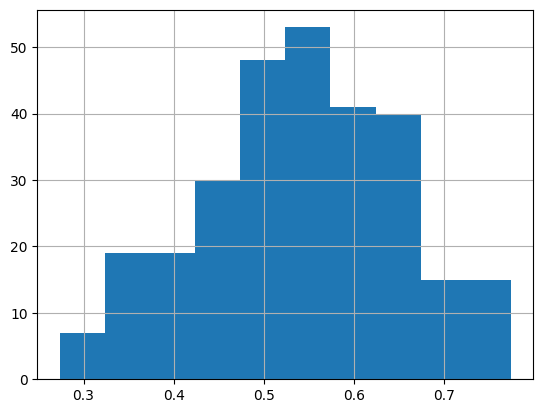

In [19]:
predicted_probs_df.home_prob_k_multi_small_auto_coeff_use_draw.hist()

In [20]:
''' 
CHOSEN MODEL : k_multi_small_auto_coeff_use_draw
'''
elo_model = EloClassifier(team_names, 1500, k=12, alpha=0.8, home_adv=28, mov_exp=1.5, mov_bias=0.3, auto_coeff=0.018, auto_bias=9.2, k_mult='538', use_draw=True)
elo_model.fit(train_df)
log_loss = elo_model.score(val_df, val_df[['home_win']].values)
print(f"log loss = {log_loss}")
rankings = elo_model.return_sorted_list()

log loss = 0.6644771975075382


In [21]:
rankings

[('Boston', 1601.0646830062885),
 ('Dallas', 1569.1801789013925),
 ('Los Angeles', 1563.8708258194545),
 ('Vegas', 1557.7539099876278),
 ('NY Rangers', 1555.9303720837281),
 ('Edmonton', 1552.9740681204003),
 ('Colorado', 1541.9531224431455),
 ('Toronto', 1541.5184317980422),
 ('Florida', 1535.1913761667333),
 ('Vancouver', 1531.948372825864),
 ('New Jersey', 1526.673736305464),
 ('Winnipeg', 1526.4320323336335),
 ('Carolina', 1523.7123315519236),
 ('NY Islanders', 1517.1365205801894),
 ('Minnesota', 1513.5394754101887),
 ('Pittsburgh', 1513.1017524918154),
 ('Tampa Bay', 1509.2981279693201),
 ('Ottawa', 1504.495804364711),
 ('Calgary', 1495.25375627793),
 ('Detroit', 1490.491511592243),
 ('Nashville', 1489.3921438056927),
 ('Seattle', 1485.9797718528791),
 ('Washington', 1479.1863785530666),
 ('Buffalo', 1478.0027510515351),
 ('Philadelphia', 1472.0199002340705),
 ('Arizona', 1464.0320799508745),
 ('St Louis', 1458.4803593893769),
 ('Montreal', 1415.3876024877038),
 ('Chicago', 1404.1

## Answers to Questions

In [53]:
print(f"1) Expected (indepedent of context) Best = {rankings[0]}, \n Expected Worst = {rankings[-1]}")
probs = elo_model.predict_proba( pd.DataFrame([[0,'Nashville', 'Florida']], columns=['numeric_season', 'home_team', 'away_team']) , update_ratings=False)
print(f"2) Florida Win_Prob (as away team) against NSH = {np.round(probs[0,1], 3)}")
boston_ranking = rankings[0][1]
boston_win_prob_against_avg_team = elo_model.win_prob(boston_ranking, np.mean(list(elo_model.elo_scores_dict.values())))    # average ranking 1500 by construction
print(f"3) Expect Boston to win {np.round(boston_win_prob_against_avg_team*100, 2)}% of their remaining matches")


1) Expected (indepedent of context) Best = ('Boston', 1601.0646830062885), 
 Expected Worst = ('Anaheim', 1383.3402013173363)
2) Florida Win_Prob (as away team) against NSH = 0.526
3) Expect Boston to win 64.16% of their remaining matches


In [ ]:
#######################